In [1]:
!pip install opendatasets

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import os
import opendatasets as od
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# seed the random number generator for consistent results
# from run to run
random.seed(1234)

In [3]:
# loading of the data in this cell based on Maha's cv_project
od.download("https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification")

# Define the path to the main images folder
IMAGE_DIR = './recyclable-and-household-waste-classification/images/images'
TRAIN_DIR = './split_dataset/train/images'
TEST_DIR = './split_dataset/test/images'
#VALIDATION_DIR = './split_dataset/val/images'   # not using, but would be easy to do

# Traverse the subdirectories and list images
image_paths = []
for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        # Append full path for each image file
        image_paths.append(os.path.join(root, file))

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: maha9876
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification


100%|██████████| 920M/920M [00:11<00:00, 83.1MB/s]


In [4]:
# Print total number of images
print(len(image_paths))

15000


./recyclable-and-household-waste-classification/images/images/aluminum_food_cans/real_world/Image_143.png


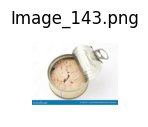

./recyclable-and-household-waste-classification/images/images/cardboard_packaging/real_world/Image_127.png


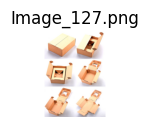

./recyclable-and-household-waste-classification/images/images/office_paper/default/Image_26.png


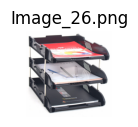

./recyclable-and-household-waste-classification/images/images/aerosol_cans/real_world/Image_224.png


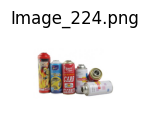

./recyclable-and-household-waste-classification/images/images/eggshells/default/Image_206.png


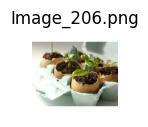

In [5]:
# Display a few random sample images
NUM_SAMPLES_TO_DISPLAY = 5

for i in range(NUM_SAMPLES_TO_DISPLAY):
    image_path = image_paths[random.randrange(len(image_paths))]
    print(image_path)
    image = Image.open(image_path)

    # Display the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.show()

In [6]:
DEFAULT_DIR = "default"
REAL_WORLD_DIR = "real_world"

# Ensure directories exist
os.makedirs(TRAIN_DIR, exist_ok = True)
os.makedirs(TEST_DIR, exist_ok = True)

def default_or_realworld(image_path):
    # this is kind of hacky to look for it as a string
    # a better way would be to step "up" one directory and see what it is
    if DEFAULT_DIR in image_path.lower():
        return DEFAULT_DIR
    elif REAL_WORLD_DIR in image_path.lower():
        return REAL_WORLD_DIR
    else:
        raise ValueError(image_path + " does not contain " + DEFAULT_DIR + " or " + REAL_WORLD_DIR)

# Process each class in the source directory
for class_name in os.listdir(IMAGE_DIR):
    class_path = os.path.join(IMAGE_DIR, class_name)
    if os.path.isdir(class_path):  # Ensure it’s a directory (class folder)
        print("Processing " + class_name + "...")

        # Create class folders in train and test directories
        os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok = True)
        os.makedirs(os.path.join(TEST_DIR, class_name), exist_ok = True)

        # Collect all image file paths from any subdirectories within this class folder
        images = []
        for root, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
                    images.append(os.path.join(root, file))

        # Shuffle and split images into 80/20 train/test
        random.shuffle(images)
        split_idx = int(len(images) * 0.8)
        train_images = images[: split_idx]
        test_images = images[split_idx :]

        # Copy images to train and test directories
        # there are duplicate file names in the default and real
        # world directories, so add that onto the names to make them
        # unique. also only copy if not already present so subsequent
        # runs are faster if this is already done
        for image_path in train_images:
            dest_path = os.path.join(TRAIN_DIR, class_name, default_or_realworld(image_path) + os.path.basename(image_path))
            if os.path.exists(dest_path) == False:
                shutil.copyfile(image_path, dest_path)

        for image_path in test_images:
            dest_path = os.path.join(TEST_DIR, class_name, default_or_realworld(image_path) + os.path.basename(image_path))
            if os.path.exists(dest_path) == False:
                shutil.copyfile(image_path, dest_path)

print("Dataset successfully split into train and test folders!")

Processing aerosol_cans...
Processing disposable_plastic_cutlery...
Processing eggshells...
Processing office_paper...
Processing steel_food_cans...
Processing plastic_straws...
Processing styrofoam_cups...
Processing cardboard_boxes...
Processing newspaper...
Processing clothing...
Processing aluminum_soda_cans...
Processing glass_food_jars...
Processing plastic_cup_lids...
Processing coffee_grounds...
Processing cardboard_packaging...
Processing plastic_soda_bottles...
Processing tea_bags...
Processing food_waste...
Processing plastic_trash_bags...
Processing paper_cups...
Processing magazines...
Processing plastic_shopping_bags...
Processing plastic_water_bottles...
Processing glass_beverage_bottles...
Processing shoes...
Processing aluminum_food_cans...
Processing styrofoam_food_containers...
Processing plastic_food_containers...
Processing plastic_detergent_bottles...
Processing glass_cosmetic_containers...
Dataset successfully split into train and test folders!


In [7]:
# return the valid ones too, cause if the directory
# doesn't exist then there are 0 invalid and it
# seems like everything is ok when it isn't.
def check_images(directory):
    invalid_images = []
    valid_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.png'):
                try:
                    img = Image.open(os.path.join(root, file))
                    # note: this returns none and throws an exception if invalid
                    # (I was expecting it to return a bool- exceptions shouldn't
                    # be used for flow control)
                    img.verify()  # Verify image integrity
                    valid_images.append(os.path.join(root, file))
                except Exception as e:
                    invalid_images.append(os.path.join(root, file))
    return valid_images, invalid_images

valid_train, invalid_train = check_images(TRAIN_DIR)
valid_test, invalid_test = check_images(TEST_DIR)

print("Valid train images: " + str(len(valid_train)) + ", invalid train images: " + str(len(invalid_train)))
print("Valid test images: " + str(len(valid_test)) + ", invalid test images: " + str(len(invalid_test)))

total_found = (len(valid_train) + len(invalid_train) + len(valid_test) + len(invalid_test))
print("Total images found in training and testing sets: " + str(total_found))
print("Expected images from source: " + str(len(image_paths)))
if  total_found != len(image_paths):
    print("MISSING FILES IN TESTING OR TRAINING SET!!!")
else:
    print("Found all expected files in training and testing")

Valid train images: 12000, invalid train images: 0
Valid test images: 3000, invalid test images: 0
Total images found in training and testing sets: 15000
Expected images from source: 15000
Found all expected files in training and testing


In [13]:
# Define data transformations
IMG_SIZE = 224
BATCH_SIZE = 64
custom_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images to a consistent size
    transforms.ToTensor(),                   # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

# Load datasets
train_dataset = ImageFolder(root=TRAIN_DIR, transform=custom_transform)
val_loader_dataset = ImageFolder(root=TEST_DIR, transform=custom_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_loader_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Check for missing classes in train and validation
train_class_names = train_dataset.classes
test_class_names = val_loader_dataset.classes
class_names = list(set(train_class_names + test_class_names))  # Maintain order
num_classes = len(class_names)
print("Class labels:", class_names)
print("\nNumber of classes: " + str(num_classes))

# Ensure training loop works correctly
for images, labels in train_loader:
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    break


Class labels: ['plastic_food_containers', 'steel_food_cans', 'glass_beverage_bottles', 'plastic_trash_bags', 'plastic_detergent_bottles', 'magazines', 'plastic_cup_lids', 'styrofoam_food_containers', 'glass_food_jars', 'office_paper', 'food_waste', 'newspaper', 'paper_cups', 'glass_cosmetic_containers', 'cardboard_boxes', 'aluminum_soda_cans', 'plastic_straws', 'plastic_water_bottles', 'plastic_soda_bottles', 'disposable_plastic_cutlery', 'coffee_grounds', 'tea_bags', 'clothing', 'aluminum_food_cans', 'cardboard_packaging', 'shoes', 'eggshells', 'plastic_shopping_bags', 'aerosol_cans', 'styrofoam_cups']

Number of classes: 30
Images shape: torch.Size([64, 3, 224, 224]), Labels shape: torch.Size([64])


In [11]:
# Import necessary modules
from torchvision.models import resnet18, ResNet18_Weights

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the ResNet18 model with the updated weights parameter
weights = ResNet18_Weights.DEFAULT  # Use default weights
model = resnet18(weights=weights)

# Adjust the final fully connected layer to match the number of classes in the dataset
num_classes = len(train_dataset.classes)  # Get the number of classes from the dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the available device (GPU/CPU)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize lists to store loss, accuracy, and other metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# Training loop with tracking
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy for the current batch
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    correct, total = 0, 0
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Validation loss
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect all predictions and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average validation loss and metrics for this epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average='weighted') * 100
    recall = recall_score(all_labels, all_preds, average='weighted') * 100
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100

    val_accuracies.append(accuracy)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1 Score: {f1:.2f}%")



Epoch [1/10], Training Loss: 1.9715, Training Accuracy: 50.74%
Validation Loss: 1.0427, Validation Accuracy: 71.90%
Precision: 72.28%, Recall: 71.90%, F1 Score: 71.18%
Epoch [2/10], Training Loss: 0.8523, Training Accuracy: 76.61%
Validation Loss: 0.7152, Validation Accuracy: 79.63%
Precision: 79.70%, Recall: 79.63%, F1 Score: 79.43%
Epoch [3/10], Training Loss: 0.5983, Training Accuracy: 83.27%
Validation Loss: 0.5846, Validation Accuracy: 82.47%
Precision: 82.47%, Recall: 82.47%, F1 Score: 82.36%
Epoch [4/10], Training Loss: 0.4657, Training Accuracy: 86.62%
Validation Loss: 0.5198, Validation Accuracy: 84.47%
Precision: 84.42%, Recall: 84.47%, F1 Score: 84.32%
Epoch [5/10], Training Loss: 0.3670, Training Accuracy: 89.56%
Validation Loss: 0.4836, Validation Accuracy: 84.80%
Precision: 85.13%, Recall: 84.80%, F1 Score: 84.49%
Epoch [6/10], Training Loss: 0.2987, Training Accuracy: 91.54%
Validation Loss: 0.4589, Validation Accuracy: 85.17%
Precision: 85.35%, Recall: 85.17%, F1 Score:

In [1]:
train_losses = [1.9715, 0.8523, 0.5983, 0.4657, 0.3670, 0.2987, 0.2428, 0.1990, 0.1692, 0.1430]
train_accuracies = [50.74, 76.61, 83.27, 86.62, 89.56, 91.54, 93.25, 94.59, 95.32, 96.03]
val_losses = [1.0427, 0.7152, 0.5846, 0.5198, 0.4836, 0.4589, 0.4441, 0.4325, 0.4345, 0.4290]
val_accuracies = [71.90, 79.63, 82.47, 84.47, 84.80, 85.17, 86.00, 86.30, 86.30, 86.47]
val_precisions = [72.28, 79.70, 82.47, 84.42, 85.13, 85.35, 86.18, 86.36, 86.73, 86.50]
val_recalls = [71.90, 79.63, 82.47, 84.47, 84.80, 85.17, 86.00, 86.30, 86.30, 86.47]
val_f1_scores = [71.18, 79.43, 82.36, 84.32, 84.49, 85.08, 85.86, 86.22, 86.11, 86.37]

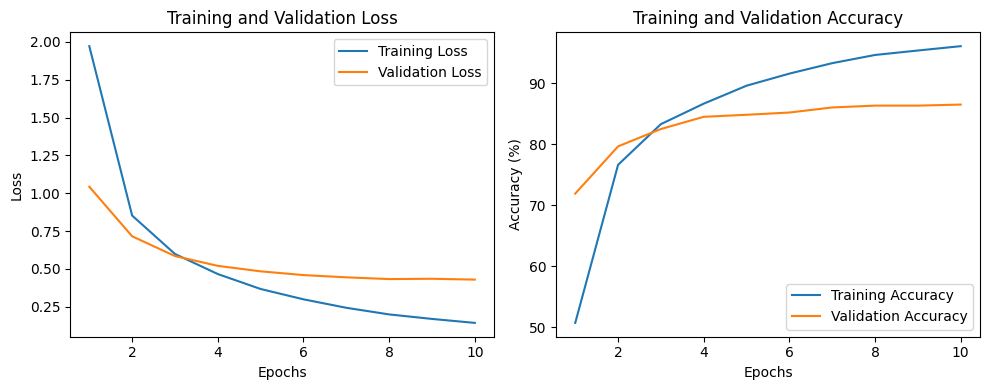

In [4]:
import matplotlib.pyplot as plt


# Define the number of epochs
epochs = range(1, len(train_losses) + 1)

# Create the plots
plt.figure(figsize=(10, 4))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [5]:
# Metrics from 10 epochs
precision = [72.28, 79.70, 82.47, 84.42, 85.13, 85.35, 86.18, 86.36, 86.73, 86.50]
recall = [71.90, 79.63, 82.47, 84.47, 84.80, 85.17, 86.00, 86.30, 86.30, 86.47]
f1_score = [71.18, 79.43, 82.36, 84.32, 84.49, 85.08, 85.86, 86.22, 86.11, 86.37]

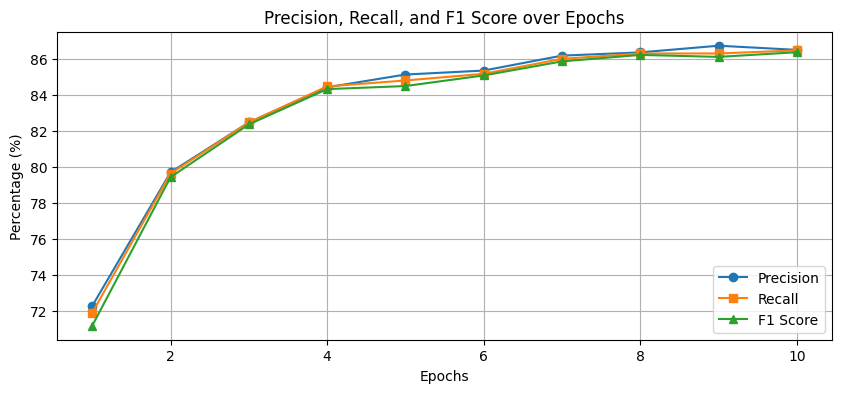

In [7]:
import matplotlib.pyplot as plt

# Create a range for epochs
epochs = range(1, 11)

# Plot the metrics
plt.figure(figsize=(10, 4))
plt.plot(epochs, precision, label='Precision', marker='o')
plt.plot(epochs, recall, label='Recall', marker='s')
plt.plot(epochs, f1_score, label='F1 Score', marker='^')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Percentage (%)')
plt.title('Precision, Recall, and F1 Score over Epochs')
plt.legend(loc='lower right')

# Show grid and plot
plt.grid(True)
plt.show()
